In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk

In [5]:
df=pd.read_csv('Reviews.csv')

## EDA

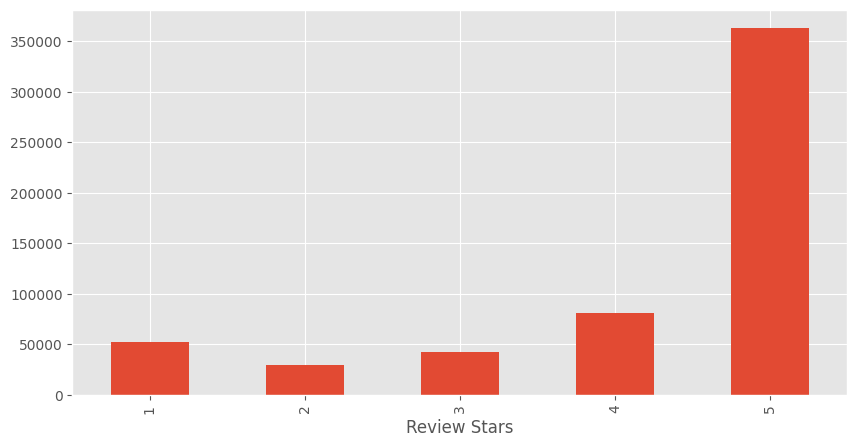

In [8]:
ax=df['Score'].value_counts().sort_index().plot(kind='bar',figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

a very biased dataset towards positive reviews

## Using NLTK

In [20]:
tokens=nltk.word_tokenize(df['Text'][3])
tagged=nltk.pos_tag(tokens)
entities=nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  If/IN
  you/PRP
  are/VBP
  looking/VBG
  for/IN
  the/DT
  secret/JJ
  ingredient/NN
  in/IN
  Robitussin/NNP
  I/PRP
  believe/VBP
  I/PRP
  have/VBP
  found/VBN
  it/PRP
  ./.
  I/PRP
  got/VBD
  this/DT
  in/IN
  addition/NN
  to/TO
  the/DT
  (ORGANIZATION Root/NNP Beer/NNP)
  Extract/NNP
  I/PRP
  ordered/VBD
  (/(
  which/WDT
  was/VBD
  good/JJ
  )/)
  and/CC
  made/VBD
  some/DT
  cherry/JJ
  soda/NN
  ./.
  The/DT
  flavor/NN
  is/VBZ
  very/RB
  medicinal/JJ
  ./.)


## Using BagOfWords technique for sentiment scoring

In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia=SentimentIntensityAnalyzer()

In [29]:
sia.polarity_scores(df['Text'][5])

{'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883}

In [37]:
#Running polarity score on the entire dataset
res={}
for i,row in tqdm(df.iterrows(),total=len(df)):
    text=row['Text']
    myid=row['Id']
    res[myid]=sia.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [41]:
vaders=pd.DataFrame(res).T
vaders=vaders.reset_index().rename(columns={'index':'Id'})
vaders=vaders.merge(df,how='left')

In [43]:
## Lets see if the results are perfomed well enough given the condition that a higer rating will most likely be a positive review

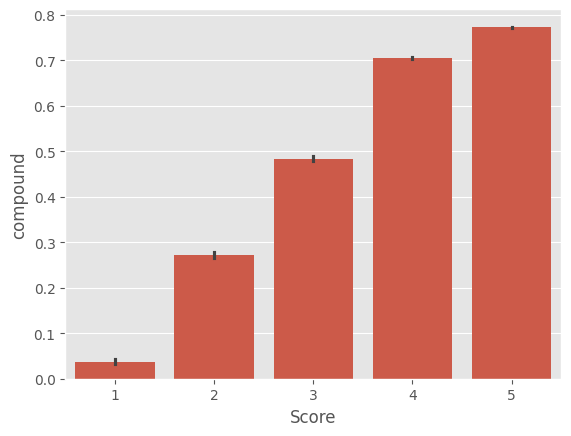

In [44]:
sns.barplot(data=vaders,x='Score',y='compound')
ax.set_title('Compound Score by Amazon star reviews')
plt.show()

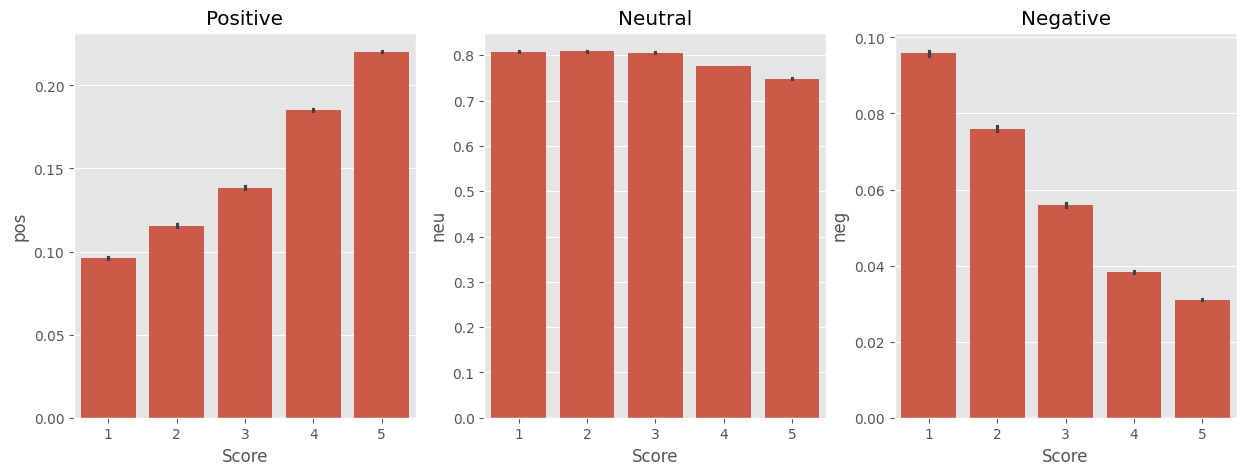

In [46]:
fig, axs=plt.subplots(1,3,figsize=(15,5))
sns.barplot(data=vaders, x='Score',y='pos',ax=axs[0])
sns.barplot(data=vaders, x='Score',y='neu',ax=axs[1])
sns.barplot(data=vaders, x='Score',y='neg',ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

## The above did not focus on the relationship between the words that is the semantic relationship. So we now look at huggingFace

In [50]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [57]:
import torch
Model=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(Model)
model=AutoModelForSequenceClassification.from_pretrained(Model)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Starting with Roberta

In [58]:
encoded=tokenizer(df['Text'][5],return_tensors='pt')
output=model(**encoded)
scores=output[0][0].detach().numpy()
scores=softmax(scores)
scores_dict={
    'neg_trans': scores[0],
    'neu_trans': scores[1],
    'pos_trans': scores[2]}


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [63]:
def polarity_scores_roberta(example):
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    model.to(device)

    encoded = tokenizer(example, return_tensors='pt',truncation=True, max_length=512, padding='max_length')
    for key in encoded:
        encoded[key] = encoded[key].to(device)

    # Perform inference
    with torch.no_grad():  # Disable gradient calculations for inference
        output = model(**encoded)

    # Extract and process scores
    scores = output[0][0].detach().cpu().numpy()  # Move scores to CPU for further processing
    scores = softmax(scores)
    scores_dict = {
        'neg_trans': scores[0],
        'neu_trans': scores[1],
        'pos_trans': scores[2]
    }

    return scores_dict


In [65]:

from transformers import pipeline


# Initialize summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Placeholder for results
res = {}

# Iterate through the DataFrame
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']

        # Summarize text if necessary (e.g., if the length is too long for RoBERTa)
        if len(text.split()) > 512:  # Adjust based on your RoBERTa model's token limit
            text = summarizer(text, max_length=512, min_length=50, truncation=True)[0]['summary_text']
            

        # Get VADER sentiment analysis
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}

        # Get RoBERTa sentiment analysis
        roberta_result = polarity_scores_roberta(text)

        # Combine both results
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both

    except RuntimeError as e:
        print(f'Error for id {myid}: {e}')


Device set to use mps:0


  0%|          | 0/568454 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [66]:
results_df=pd.DataFrame(res).T
results_df=results_df.reset_index().rename(columns={'index':'Id'})
results_df=results_df.merge(df,how='left')

In [68]:
## Compare Scores between models
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'neg_trans', 'neu_trans', 'pos_trans', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

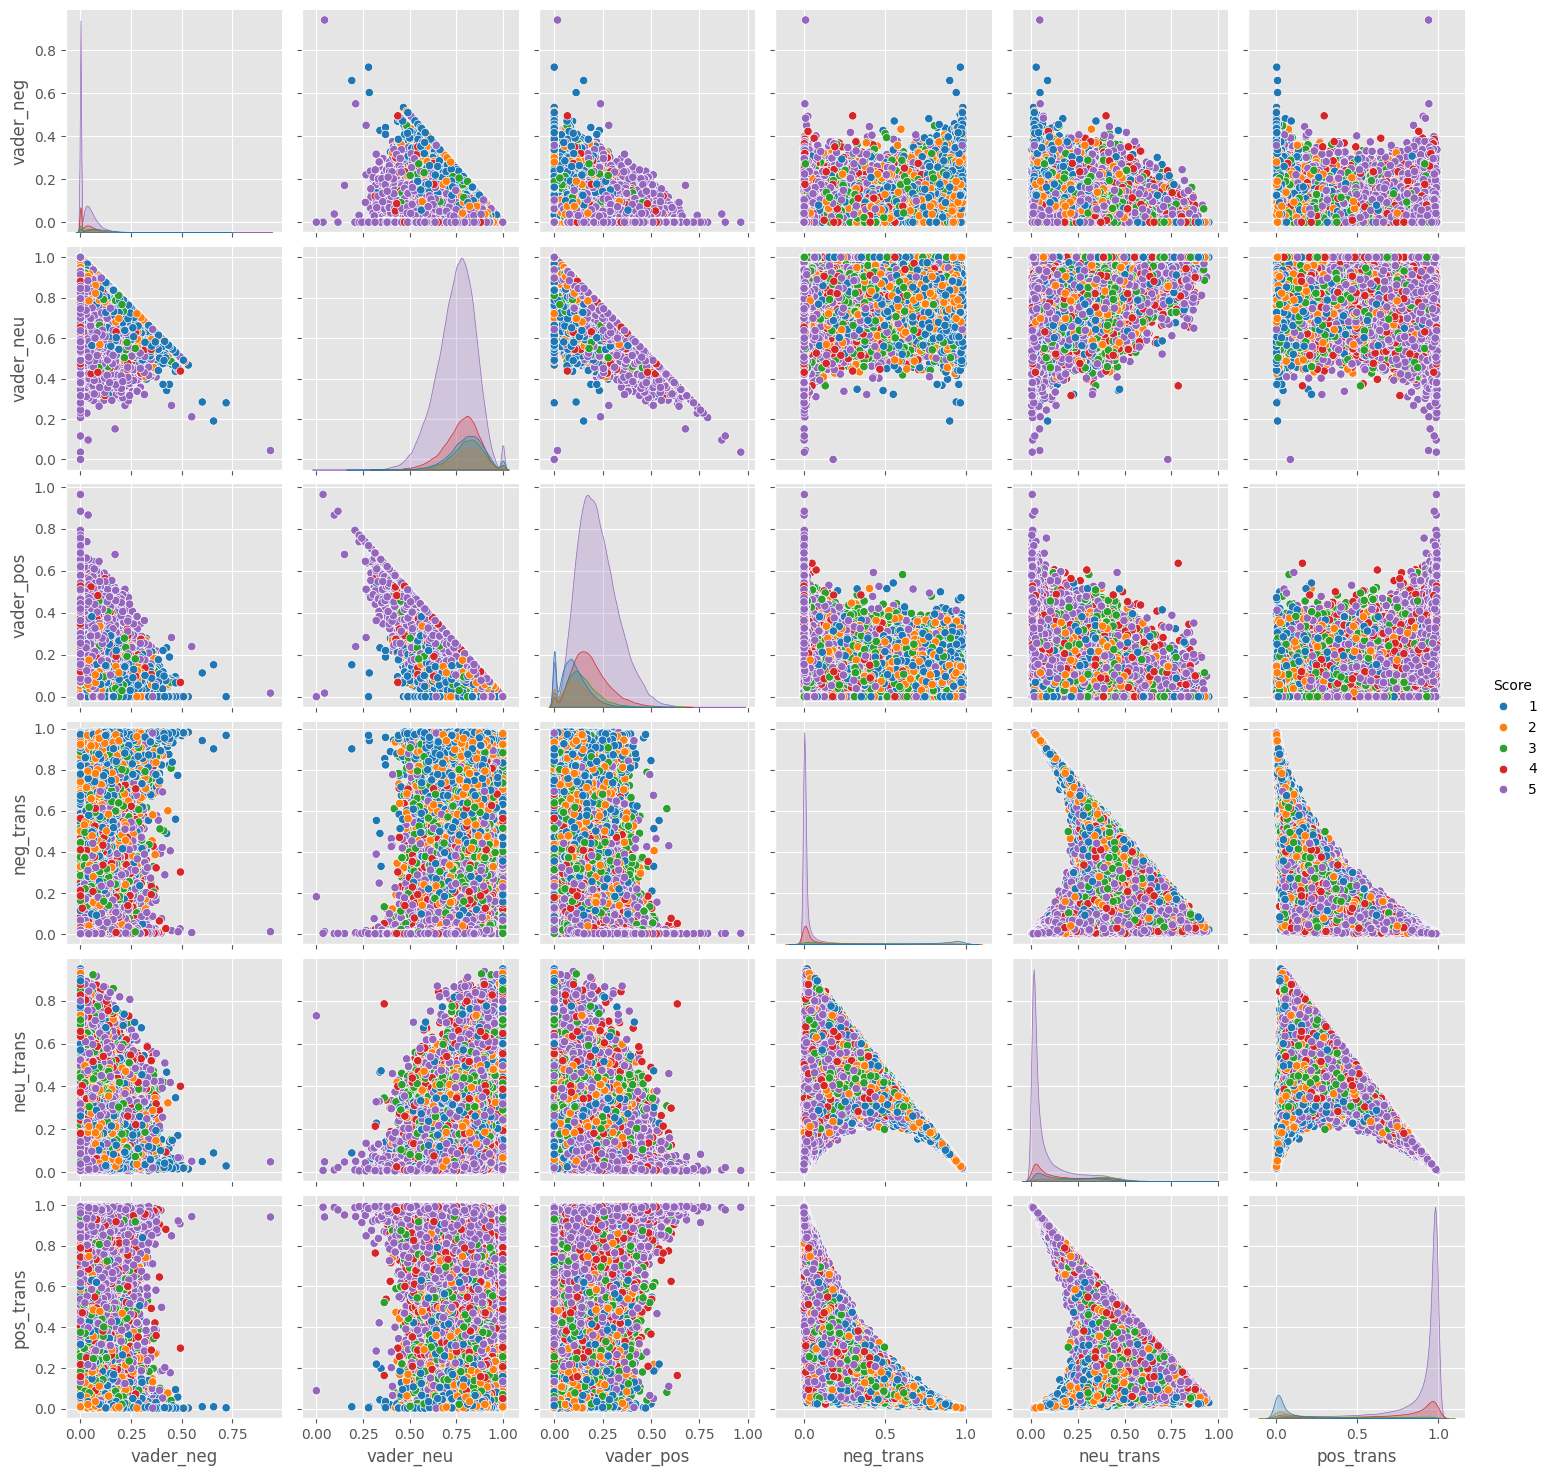

In [69]:
sns.pairplot(data=results_df,vars=['vader_neg', 'vader_neu', 'vader_pos',
       'neg_trans', 'neu_trans', 'pos_trans'],hue='Score',palette='tab10')
plt.show()

## Lets see some positive 1-star and negative 5-star reviews i.e. examples where the model scoring and review score differs the maximum

In [72]:
results_df.query('Score==1').sort_values('pos_trans',ascending=False)['Text'].values[0]

"loved it! it worked better that I expected, I can't wait to order some more.  we made bath fizzies and the came out fantastic!!!"

In [73]:
results_df.query('Score==1').sort_values('vader_pos',ascending=False)['Text'].values[0]

'Quality of product is excellent, cost is excellent and delivery is superb.  Very satisfied.'

In [ ]:
# negative sentiment 5-star review
results_df.query('Score==5').sort_values('neg_trans',ascending=False)['Text'].values[0]

In [76]:
results_df.query('Score==5').sort_values('vader_neg',ascending=False)['Text'].values[0]

'These are good but are not sweet! Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good, Good,'

## Trying out Transformers Pipeline

In [79]:
from transformers import pipeline

sent_pipeline=pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use mps:0


In [80]:
sent_pipeline("That was such a good food. I hope it was my last!")

[{'label': 'POSITIVE', 'score': 0.9998119473457336}]

The above code shows how these models are weak in capturing humor

In [82]:
sent_pipeline("I loved her except the families. I wish we coould be together in some other timeline.")

[{'label': 'NEGATIVE', 'score': 0.9848924875259399}]

In [83]:
sent_pipeline("My Name is Spandan Roy and this is my project")

[{'label': 'POSITIVE', 'score': 0.9995563626289368}]